# Predict The Stock Market Using Machine Learning

In this project, I will work with time series data which is S&P 500 index. I get the dataframe by using yfinance package. Each row of datafrme is the price on asingle trading day from year 1950 to 2022. Here are the columns:
- Open: Indicates the price when the market opened.
- High: Highest price during the day.
- Low: Lowest price during the day.
- Close: Indicates the price when the exchange closed.
- Volume: Indicates the total number of shares traded.

**Goal** : To predict the index whether go up or down <br>
**Metric** : Precision score

In [1]:
# Install and import modules
!pip install os
!pip install yfinance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
# Check if we have csv file already, if not go download it.
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,0,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,0,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,0,0


# Explore data and data cleaning

- Drop Dividends, Stock Splits columns.
- Plot time series of Close price.
- Generate target column.
- Change index type of dataframe to datatime.
- Filter old data (before 1990) out.

In [3]:
# Drop some columns that we're not going to use. These 2 columns are more apporpriate for individual stock not for index
sp500 = sp500.drop(['Dividends','Stock Splits'], axis = 1)
sp500

,Open,High,Low,Close,Volume
Date,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000
...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000


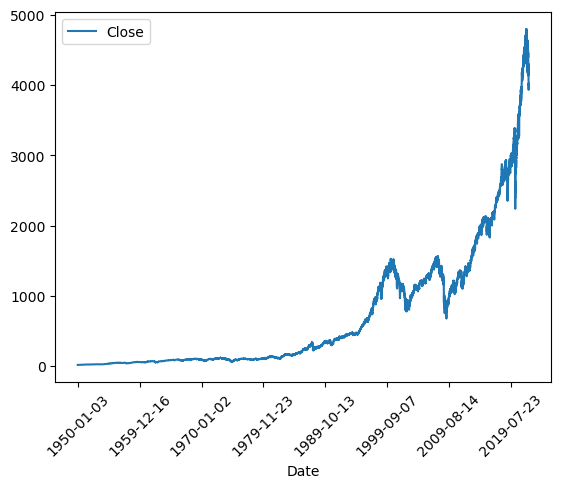

In [4]:
# Explore data
%matplotlib inline
sp500.plot.line(y='Close', use_index = True)
plt.xticks(rotation = 45)
plt.show()

In [5]:
# Create target column by shift Close column -1 period as tommorrow
sp500['tomorrow'] = sp500['Close'].shift(periods= -1, axis=0)
sp500

,Open,High,Low,Close,Volume,tomorrow
Date,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,16.850000
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,16.930000
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,16.980000
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,17.080000
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,17.030001
...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893


In [6]:
# Then compare close column and tomorrow as a target column (go up = 1, go down = 0)
sp500['target'] = (sp500['Close'] < sp500['tomorrow']).astype(int)
sp500

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,16.850000,1
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,16.930000,1
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,16.980000,1
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,17.080000,1
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,17.030001,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1


In [7]:
# Change index of dataframe to datetime type 
sp500.index = sp500.index.astype('datetime64[ns]')
# Because old data cant be useful for the prediction and the market could have shift fundamentally. We select year more than 1990 analyze from graph above
sp500 = sp500.copy()[sp500.index.year >= 1990]
sp500

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1


# Training an Initial Machine Learning Model

- Instantiate model (Randomforest) for classifier problem
- Split train / test data (100 rows for test data) 
- Select predictors and target 
- measure errors by using recall

In [8]:
# Instantiate model (Randomforest), train, test data 
rf = RandomForestClassifier(n_estimators= 100,random_state = 1, min_samples_split=100)
train = sp500.copy().iloc[:-100]
test = sp500.copy().iloc[-100:]
train

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2021-12-15,4636.459961,4712.600098,4611.220215,4709.850098,3367580000,4668.669922,0
2021-12-16,4719.129883,4731.990234,4651.890137,4668.669922,3592810000,4620.640137,0
2021-12-17,4652.500000,4666.700195,4600.220215,4620.640137,5609780000,4568.020020,0


In [9]:
test

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
2021-12-22,4650.359863,4697.669922,4645.529785,4696.560059,2439570000,4725.790039,1
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,2194630000,4791.189941,1
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,2264120000,4786.350098,0
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,2217050000,4793.060059,1
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,2369370000,4778.729980,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1


In [10]:
#Split train target, train predictors, test target, test predictors
train_tg = train['target']
train_col = train.copy().drop(['tomorrow','target'],axis=1)
test_tg = test['target']
test_col = test.copy().drop(['tomorrow','target'],axis=1)
rf.fit(train_col,train_tg)
pred = rf.predict(test_col)
predict = pd.Series(pred, index = test.index)
train.shape

(8057, 7)

In [11]:
test_col

,Open,High,Low,Close,Volume
Date,,,,,
2021-12-22,4650.359863,4697.669922,4645.529785,4696.560059,2439570000
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,2194630000
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,2264120000
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,2217050000
2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,2369370000
...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000


In [12]:
precision_score(test_tg,predict)

0.4155844155844156

Precision score is 0.4155844155844156 <br>
So, we actually correct 41.56 percent when we predict index will go up.

In [13]:
from sklearn.metrics import recall_score
recall_score(test_tg,predict)

0.7441860465116279

In [14]:
combined = pd.concat([test_tg,predict],axis=1)
combined.columns = ['target','predict']
combined

,target,predict
Date,,
2021-12-22,1,1
2021-12-23,1,0
2021-12-27,0,0
2021-12-28,1,0
2021-12-29,0,0
...,...,...
2022-05-10,0,1
2022-05-11,0,0
2022-05-12,1,0


<AxesSubplot:xlabel='Date'>

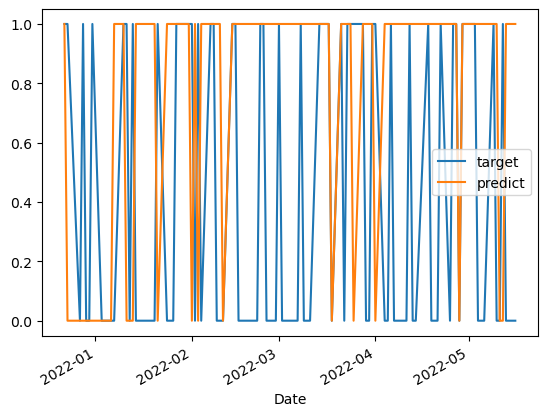

In [15]:
combined.plot.line()

This graph is target vs prediction values along with date.
It seems our prediction is going up but the target is going down. Our model is not good enough.
So we need improvement.

# Model Improvement

- Create function that takes in train set, test set, predictors and model for training data.
- Create function that can apply predictive model to historical data to determine its accuracy (backtesting) 
   - Aggregate strategy
   
   
   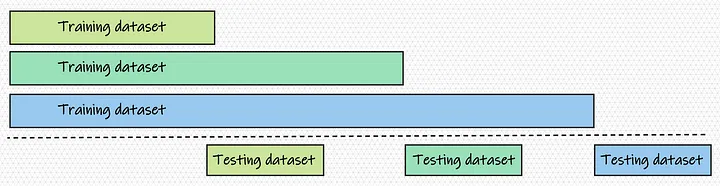

In [16]:
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['target'])
    predict = model.predict(test[predictors])
    predict = pd.Series(predict, index = test.index, name= 'predictions')
    combined = pd.concat([test['target'], predict], axis= 1)
    return combined

In [17]:
def backtest(data, model, predictors, start=2500, step = 250): # Assume 1 year = 250 days trade start at 10 years and plus 1 year over
    all_predictions  = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)
predictors = ['Open','High','Low','Close','Volume']
predict = backtest(sp500,rf,predictors)

In [18]:
predict

,target,predictions
Date,,
1999-11-22,0,0
1999-11-23,1,0
1999-11-24,0,0
1999-11-26,0,0
1999-11-29,0,0
...,...,...
2022-05-10,0,1
2022-05-11,0,0
2022-05-12,1,1


In [19]:
predict['predictions'].value_counts()

0    3305
1    2352
Name: predictions, dtype: int64

Same model + Backtesting, we predict index will go up 2352, go down 3305 days

In [20]:
precision_score(predict['target'],predict['predictions'])

0.5314625850340136

Precision score is 0.5314625850340136 <br>
So, we actually correct 53.15 percent when we predict index will go up. More than initial model above but Is it good enough?

In [21]:
predict['target'].value_counts() / predict.shape[0]

1    0.536857
0    0.463143
Name: target, dtype: float64

- **Consider benchmark for model** <br>
We compare our precision score with benchmark by selecting all index days that actually go up divide by all index days<br>
>**(Benchmark) 53.69 percent vs (Precision score) 53.15 percent**.<br>
Thus, our model is same result as benchmark. We should improve more.

In [22]:
sp500

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1


In [23]:
sp500.shift(1).rolling(2).sum()

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,713.089996,720.279999,709.870026,718.450012,3.544000e+08,714.430023,0.0
1990-01-05,718.450012,719.350006,710.780029,714.430023,3.693300e+08,707.870026,0.0
1990-01-08,714.430023,714.430023,704.240021,707.870026,3.355300e+08,705.990021,1.0
...,...,...,...,...,...,...,...
2022-05-10,8209.439941,8238.959961,8043.389893,8114.579834,9.000420e+09,7992.290039,1.0
2022-05-11,8116.449951,8150.090088,7933.649902,7992.290039,9.376270e+09,7936.229980,1.0
2022-05-12,8025.260010,8117.910156,7886.989990,7936.229980,9.313370e+09,7865.260010,0.0


# Model Improvement (cont.)

- We generate other predictors
    - we use trend of 2,5,60,250,1000 days and sum target values
    $$ trend_{h} = target_{1} + target_{2} + ... + target_{h} $$
    - we use close ratio of 2,5,60,250,1000 days which are close index of that day divide by rolling average of close index in 2,5,60,250,1000 days
    $$ close_{h} = \frac{close_{date}} {\frac{close_{1} + close_{2} + ... + close_{h}}{h}} $$

In [24]:
# Generate other predictors and gather all
horizons = [2,5,60,250,1000]
nw_predictors = []
for horizon in horizons:
    rolling_avg = sp500.rolling(horizon).mean()
    ratio_column = f'close_ratio_{horizon}'
    sp500[ratio_column] = sp500['Close'] / rolling_avg['Close']
    trend_column = f'trend_{horizon}'
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['target']
    nw_predictors += [ratio_column,trend_column]
nw_predictors += predictors

In [25]:
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,tomorrow,target,close_ratio_2,trend_2,close_ratio_5,trend_5,close_ratio_60,trend_60,close_ratio_250,trend_250,close_ratio_1000,trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,4081.270020,4081.270020,3975.479980,3991.239990,4746120000,4001.050049,1,0.983721,0.0,0.962343,2.0,0.914756,26.0,0.898738,132.0,1.158960,553.0
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0,1.001227,1.0,0.972892,2.0,0.918469,27.0,0.901037,132.0,1.161381,553.0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0,0.991700,1.0,0.974166,1.0,0.904963,27.0,0.886394,131.0,1.141860,553.0


In [26]:
# Update predict function predict target by prob = 0.6
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['target'])
    predict = model.predict_proba(test[predictors])[:,1]
    predict[predict >= 0.6] = 1
    predict[predict < 0.6] = 0
    predict = pd.Series(predict, index = test.index, name= 'predictions')
    combined = pd.concat([test['target'], predict], axis= 1)
    return combined

In [27]:
# Change model argument 
model = RandomForestClassifier(n_estimators= 100, random_state = 1, min_samples_split=100)
prediction = backtest(sp500, model, nw_predictors)

In [28]:
prediction['predictions'].value_counts()

0.0    4207
1.0     449
Name: predictions, dtype: int64

In [29]:
precision_score(prediction['target'],prediction['predictions'])

0.5812917594654788

Precision score is 0.5812917594654788
It seem we have good model enough because our model have precision score more than benchmark.